In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os

# Train, Test
from sklearn.model_selection import train_test_split

# Modelos
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Métricas
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
# Cargamos el scaler que usamos para escalar los datos previamente

with open('escaladores/x_scaler.pkl', 'rb') as file:
    x_scaler = pickle.load(file)
    
with open('escaladores/y_scaler.pkl', 'rb') as file:
    y_scaler = pickle.load(file)

In [4]:
df = pd.read_csv("../bin/data_process.csv")

In [5]:
# Quitamos el precio nuevo porque a Miguel le parece que es hacer trampa

x = df.drop(columns = ['precio_contado'], axis=1)  
y = df['precio_contado']  

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=33)

In [6]:
modelos = {
    "random_forest": RandomForestRegressor(),
    "decision_tree": DecisionTreeRegressor(),
    "gradient_boosting": GradientBoostingRegressor(),
    "adaboost": AdaBoostRegressor(),
    "kneighbors": KNeighborsRegressor(),
    "linear_regressor": LinearRegression(),
    "svr": SVR()
}

In [7]:
%%time
resultados = []

for regresor, modelo in modelos.items():
    modelo.fit(x_train, y_train)
    
    y_pred = modelo.predict(x_test)
    y_pred_unscaled = y_scaler.inverse_transform(np.array(y_pred).reshape(-1, 1)).ravel()
    y_test_unscaled = y_scaler.inverse_transform(np.array(y_test).reshape(-1, 1)).ravel()
    
    mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
    mse = mean_squared_error(y_test_unscaled, y_pred_unscaled)
    r2 = r2_score(y_test_unscaled, y_pred_unscaled)
    
    resultados.append({'Nombre_modelo': regresor, 'MAE': mae, 'MSE': mse, 'R2_score': r2})
    
df_resultados = pd.DataFrame(resultados)
df_resultados = df_resultados.sort_values(by = "R2_score", ascending = False)

df_resultados.to_pickle(f'modelo/resultados_modelos.pkl')

CPU times: total: 3.69 s
Wall time: 3.61 s


In [8]:
df_resultados

,Nombre_modelo,MAE,MSE,R2_score
0,random_forest,2635.416782,1.824127e+07,0.903530
2,gradient_boosting,3042.832411,2.057000e+07,0.891214
6,svr,3056.803930,2.238230e+07,0.881629
4,kneighbors,3184.645267,2.466455e+07,0.869559
1,decision_tree,3408.333046,3.274681e+07,0.826816
5,linear_regressor,4172.751140,3.771429e+07,0.800545
3,adaboost,6047.946132,5.199001e+07,0.725046


modelo: (0.49577488027506145) 
potencia_cv: (0.17190766790407627) 
antiguedad_coche: (0.13000447740668575) 
log_kilometraje: (0.12603396939580258) 
tipo_cambio: (0.035050154519684636) 
marca: (0.023921182530883923) 
distintivo_ambiental_ECO: (0.004814813047010113) 
combustible_Gasolina: (0.003575934464445705) 
combustible_Híbrido Enchufable: (0.0031223796634222718) 
distintivo_ambiental_C: (0.002976309370609379) 
combustible_Eléctrico: (0.002640594967524653) 
distintivo_ambiental_B: (0.00014666629142726193) 
combustible_Gasolina/gas: (2.689954194550964e-05) 
combustible_Gas: (4.070621420530448e-06) 


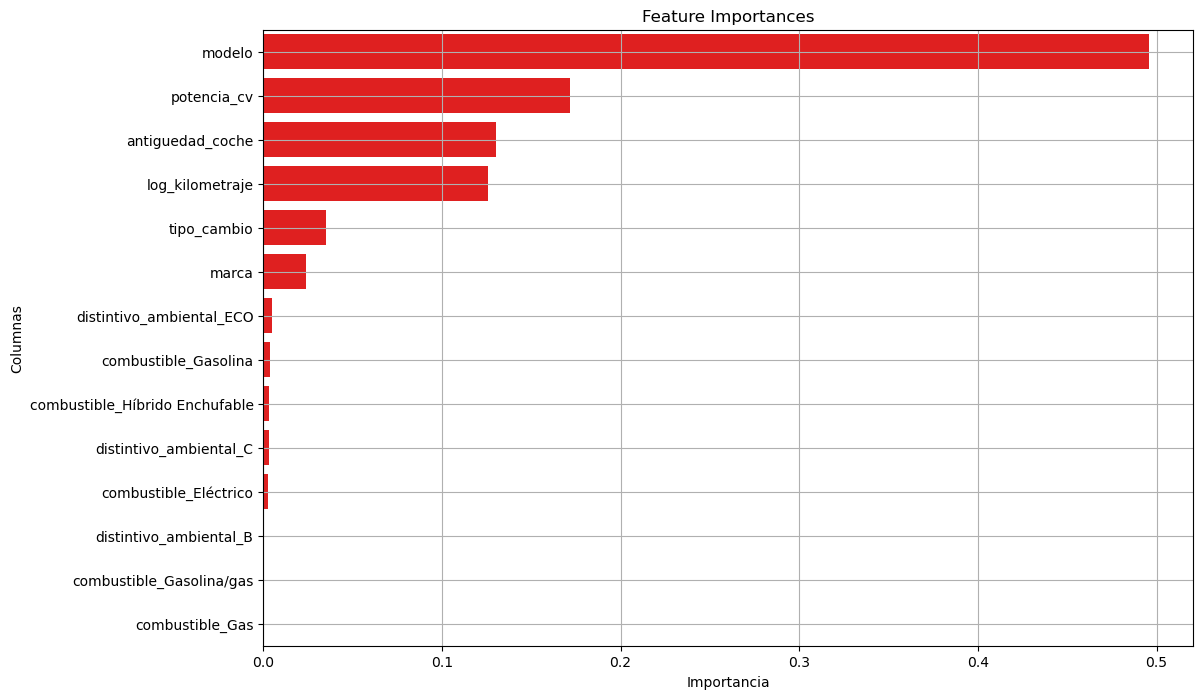

CPU times: total: 4.86 s
Wall time: 5.24 s


In [9]:
%%time
# Modelo de RandomForest para obtener Feature Importance
model = RandomForestRegressor(n_estimators = 250,
                               random_state = 33)
# Entrenamos el modelo
model.fit(x, y)

# Calculamos Feature Importance
importances = model.feature_importances_

df_importances = pd.DataFrame(data = zip(x.columns, importances),
                              columns = ["Columnas", "Importancia"])

df_importances = df_importances.sort_values("Importancia", ascending = False)

for index, (feature, importance) in enumerate(df_importances.values):
    
    print(f"{feature}: ({importance:3}) ")

plt.figure(figsize = (12, 8))

plt.title("Feature Importances")
sns.barplot(x = df_importances["Importancia"], y = df_importances["Columnas"], color = "red")

plt.grid()
plt.show()

%%time

scorers = {
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
    'MSE': make_scorer(mean_squared_error, greater_is_better=False),
    'R2': make_scorer(r2_score)}



params = {"n_estimators"           : [100, 150],
          "criterion"              : ["squared_error", "absolute_error"], 
          "max_depth"              : [10, 15],
          "max_leaf_nodes"         : [90, 120],
          "min_samples_split"      : [2, 10],
          "random_state"           : [33]} 

grid_solver = GridSearchCV(estimator  = model     , 
                           param_grid = params    , 
                           scoring    = scorers   ,
                           cv         = 5         ,
                           refit      = "R2",
                           n_jobs     = -1        ,
                           verbose    = 3)

model_result = grid_solver.fit(x, y)

print(model_result.cv_results_["mean_test_MAE"].mean())
print(model_result.cv_results_["mean_test_MSE"].mean())
print(model_result.cv_results_["mean_test_R2"].mean())

print("*" * 100)

print(model_result.best_score_)
print(model_result.best_params_)

In [11]:
best_params = {'criterion': 'squared_error', 'max_depth': 15, 'max_leaf_nodes': 120, 'min_samples_split': 10, 'n_estimators': 150, 'random_state': 33}

In [12]:
mejor_modelo = RandomForestRegressor(**best_params)

mejor_modelo.fit(x, y)

RandomForestRegressor(max_depth=15, max_leaf_nodes=120, min_samples_split=10,
                      n_estimators=150, random_state=33)

In [13]:
resultados_mejor_modelo = []
y_pred = mejor_modelo.predict(x_test)
y_pred_unscaled = y_scaler.inverse_transform(np.array(y_pred).reshape(-1, 1)).ravel()
y_test_unscaled = y_scaler.inverse_transform(np.array(y_test).reshape(-1, 1)).ravel()

regresor = 'Random forest'
mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
mse = mean_squared_error(y_test_unscaled, y_pred_unscaled)
r2 = r2_score(y_test_unscaled, y_pred_unscaled)
    
resultados_mejor_modelo.append({'Nombre_modelo': regresor, 'MAE': mae, 'MSE': mse, 'R2_score': r2})
    
resultados_mejor_modelo = pd.DataFrame(resultados_mejor_modelo)

resultados_mejor_modelo.to_pickle(f'modelo/resultados_mejor_modelo.pkl')

resultados_mejor_modelo

,Nombre_modelo,MAE,MSE,R2_score
0,Random forest,2689.089304,1.359049e+07,0.928126


modelo: (0.5230081998034004) 
potencia_cv: (0.17324006689652188) 
antiguedad_coche: (0.12232251899521321) 
log_kilometraje: (0.11790445638465169) 
tipo_cambio: (0.03541691176461286) 
marca: (0.016753169489094784) 
distintivo_ambiental_ECO: (0.003936448056802833) 
combustible_Híbrido Enchufable: (0.002251797190085785) 
distintivo_ambiental_C: (0.001799705292643616) 
combustible_Eléctrico: (0.0017420207478484734) 
combustible_Gasolina: (0.0015608048845276077) 
distintivo_ambiental_B: (6.390049459683206e-05) 
combustible_Gas: (0.0) 
combustible_Gasolina/gas: (0.0) 


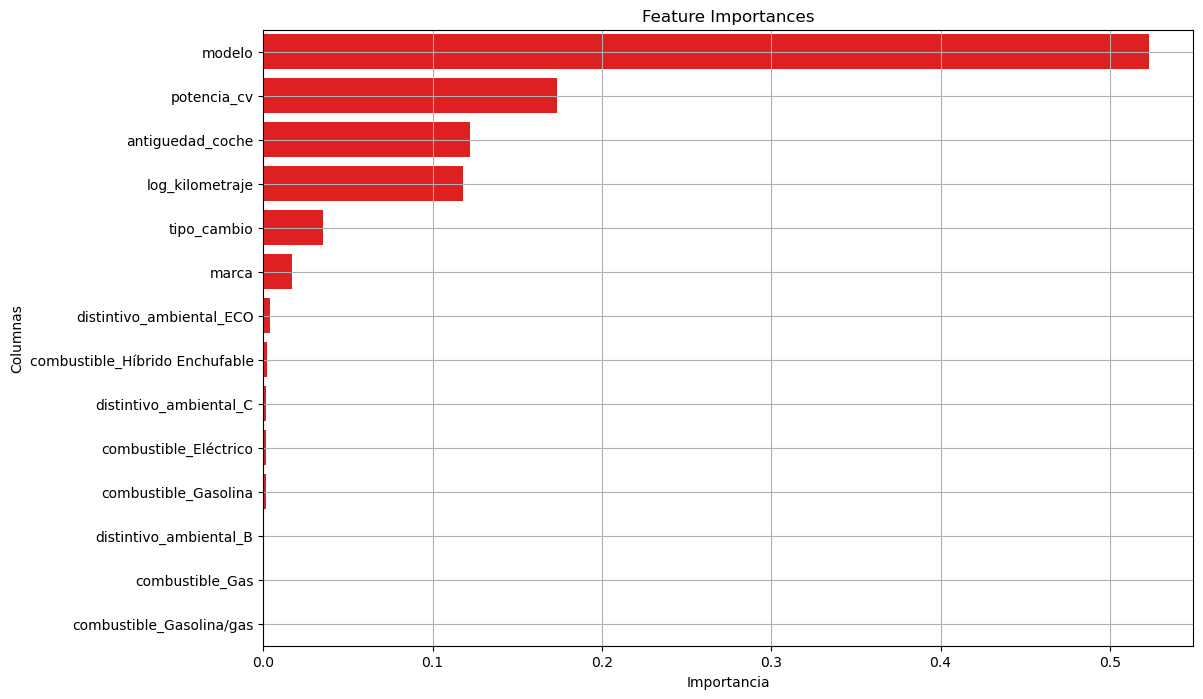

CPU times: total: 328 ms
Wall time: 427 ms


In [14]:
%%time
# Calculamos Feature Importance
importances = mejor_modelo.feature_importances_

df_importances = pd.DataFrame(data = zip(x.columns, importances),
                              columns = ["Columnas", "Importancia"])

df_importances = df_importances.sort_values("Importancia", ascending = False)

for index, (feature, importance) in enumerate(df_importances.values):
    
    print(f"{feature}: ({importance:3}) ")

plt.figure(figsize = (12, 8))

plt.title("Feature Importances")
sns.barplot(x = df_importances["Importancia"], y = df_importances["Columnas"], color = "red")

plt.grid()
plt.show()

In [15]:
#Crear una carpeta para guardar el modelo

os.makedirs("modelo", exist_ok=True)

with open("modelo/mejor_modelo.pkl", "bw") as file:
    pickle.dump(mejor_modelo, file)